In [359]:
# Required imports.

from importlib import reload

import os
import glob
import json
import pickle
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats, special
# Statsmodels is 0.10.0rc2. See
# https://github.com/statsmodels/statsmodels/issues/5747#issuecomment-502940661.
import statsmodels.api as sm
import sklearn.linear_model
import sklearn.metrics as metrics
import sklearn.utils as sk_utils
from patsy import dmatrices

In [79]:
# Generate f(X) = 5x as I did for the R code.

def simulate_univariate_ols():
    # Draw 500 samples.
    N = 500
    X = np.random.uniform(-100, 100, N)
    fX = 5 * X

    # Create variance s/t the R^2 will be 0.005.
    sd = np.sqrt(0.995 / 0.005 * np.var(fX))
    noise = np.random.normal(0, sd, size = N)

    data = np.vstack([X, fX, fX + noise]).T
    df = pd.DataFrame(data, columns=['X', 'fX', 'Y'])
    train_df = df[df.index <= 399]
    test_df = df[df.index >= 400]
    tempX = sm.add_constant(train_df['X'].values)
    model = sm.OLS(train_df['Y'].values, tempX)
    results = model.fit()
    testX = sm.add_constant(test_df['X'].values)
    modelY = results.predict(testX)
    model_mse = np.mean(np.square(modelY - test_df['Y'].values))
    oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
    model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
    oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))
    
    return [model_mse, oracle_mse, model_mae, oracle_mae]

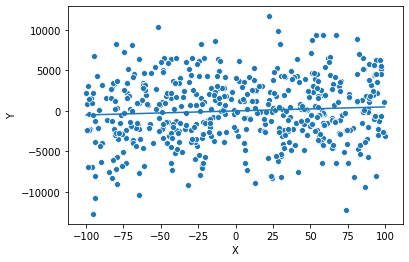

In [73]:
%matplotlib inline

ax = sns.lineplot(x = 'X', y = 'fX', data = df)
sns.scatterplot(x = 'X', y = 'Y', data = df, ax = ax)

In [74]:
train_df = df[df.index <= 399]
test_df = df[df.index >= 400]

In [75]:
tempX = sm.add_constant(train_df['X'].values)
model = sm.OLS(train_df['Y'].values, tempX)
results = model.fit()

In [76]:
testX = sm.add_constant(test_df['X'].values)
modelY = results.predict(testX)
model_mse = np.mean(np.square(modelY - test_df['Y'].values))
oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))

In [77]:
print(model_mse, oracle_mse, model_mae, oracle_mae)

19050779.539246324 19088744.690196816 3518.5899810004466 3517.528711115013


In [78]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.927
Date:                Sun, 16 Feb 2020   Prob (F-statistic):             0.0879
Time:                        15:22:32   Log-Likelihood:                -3873.9
No. Observations:                 400   AIC:                             7752.
Df Residuals:                     398   BIC:                             7760.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -48.7116    194.930     -0.250      0.803    -431.933     334.509
x1             5.7157      3.341      1.711      0.088      -0.852      12.284
==============================================================================
Omnibus:                        0.781   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.677   Jarque-Bera (JB):                0.774
Skew:                          -0.106   Prob(JB):                        0.679
Kurtosis:                       2.967   Cond. No.                         58.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
results = []
for i in range(1000):
    results.append(simulate_univariate_ols())

In [82]:
results_df = pd.DataFrame(results, columns=['Model_MSE', 'Oracle_MSE', 'Model_MAE', 'Oracle_MAE'])

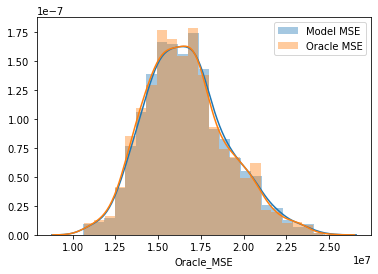

In [86]:
ax = sns.distplot(results_df['Model_MSE'], label = 'Model MSE')
sns.distplot(results_df['Oracle_MSE'], label = 'Oracle MSE', ax = ax)
ax.legend()

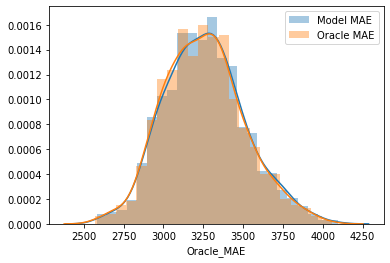

In [87]:
ax = sns.distplot(results_df['Model_MAE'], label = 'Model MAE')
sns.distplot(results_df['Oracle_MAE'], label = 'Oracle MAE', ax = ax)
ax.legend()

In [91]:
print('Model MSE Mean: ', results_df['Model_MSE'].mean(),
      'Oracle MSE Mean: ', results_df['Oracle_MSE'].mean(),
      'Difference: ', results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean())

Model MSE Mean:  16687976.52114043 Oracle MSE Mean:  16603500.740960328 Difference:  84475.78018010221


In [92]:
print('Model MAE Mean: ', results_df['Model_MAE'].mean(),
      'Oracle MAE Mean: ', results_df['Oracle_MAE'].mean(),
      'Difference: ', results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean())

Model MAE Mean:  3260.0462068072147 Oracle MAE Mean:  3252.3643801024214 Difference:  7.681826704793366


Just like in the `R` code, on average the model provides results that are close to the oracle, but slightly worse, as it should be (the oracle should be the lower bound for how good a model can be).

Next, to try linear regression on a multivariate model with normal Gaussian, and non-Gaussian errors. We'll start with the Cauchy distribution, then apply other types of distributions (eg. chi-squared, Pearson distributions, etc.)

In [ ]:
# Generate f(X) = 5x as I did for the R code.

def simulate_univariate_ols():
    # Draw 500 samples.
    N = 500
    X = np.random.uniform(-100, 100, N)
    fX = 5 * X

    # Create variance s/t the R^2 will be 0.005.
    sd = np.sqrt(0.995 / 0.005 * np.var(fX))
    noise = np.random.normal(0, sd, size = N)

    data = np.vstack([X, fX, fX + noise]).T
    df = pd.DataFrame(data, columns=['X', 'fX', 'Y'])
    train_df = df[df.index <= 399]
    test_df = df[df.index >= 400]
    tempX = sm.add_constant(train_df['X'].values)
    model = sm.OLS(train_df['Y'].values, tempX)
    results = model.fit()
    testX = sm.add_constant(test_df['X'].values)
    modelY = results.predict(testX)
    model_mse = np.mean(np.square(modelY - test_df['Y'].values))
    oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
    model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
    oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))
    
    return [model_mse, oracle_mse, model_mae, oracle_mae]

In [97]:
np.random.uniform(0, 1000, 3)

array([299.91927756, 378.46723979, 550.0109468 ])

In [100]:
# Multivariate model: f(X) = 5.01 + -7.047 * X1 + 6.65 * X2 + 3.71 * X3.
# We'll draw X1 from (-50, 50), X2 from (-300, 300), and X3 from (-500, 500).
def simulate_multivariate_ols(N):
    # Draw N samples.
    X1 = np.random.uniform(-50, 50, N)
    X2 = np.random.uniform(-300, 300, N)
    X3 = np.random.uniform(-500, 500, N)
    fX = 5.01 - 7.047 * X1 + 6.65 * X2 + 3.71 * X3
    data = np.vstack([X1, X2, X3, fX]).T
    df = pd.DataFrame(data, columns=['X1', 'X2', 'X3', 'fX'])
    return df

def generate_gaussian_noise(N, Y):
    # Draw N samples. Set standard deviation that would make
    # for 0.5% R^2.
    sd = np.sqrt(0.995 / 0.005 * np.var(Y))
    noise = np.random.normal(0, sd, size = N)
    return noise
    
def generate_cauchy_noise(N, Y):
    # Draw N samples, set at same standard deviation that would
    # make Gaussian error give 0.5% R^2.
    scale = np.sqrt(0.995 / 0.005 * np.var(Y))
    return scale * np.random.standard_cauchy(N)

In [116]:
# Results with Gaussian noise.
results = []

for i in range(1000):
    df = simulate_multivariate_ols(500)
    df['gaussian_noise'] = generate_gaussian_noise(500, df['fX'].values)
    df['Y'] = df['fX'] + df['gaussian_noise']

    train_df = df[df.index <= 399]
    test_df = df[df.index >= 400]

    tempX = sm.add_constant(train_df[['X1', 'X2', 'X3']].values)
    model = sm.OLS(train_df['Y'].values, tempX)
    fitted_model = model.fit()
    testX = sm.add_constant(test_df[['X1', 'X2', 'X3']].values)
    modelY = fitted_model.predict(testX)
    model_mse = np.mean(np.square(modelY - test_df['Y'].values))
    oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
    model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
    oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))
    results.append([model_mse, oracle_mse, model_mae, oracle_mae])

results_df = pd.DataFrame(results, columns=['model_mse', 'oracle_mse', 'model_mae', 'oracle_mae'])

Model Mean:  503420813.59858215 . Oracle mean:  498905807.9849558 . Difference:  4515005.613626361 . Difference as % of oracle:  0.009049815699404542


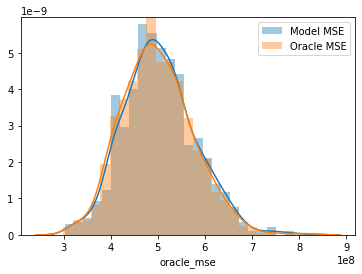

In [118]:
# Plotting the results of Gaussian noise and MSE.
ax = sns.distplot(results_df['model_mse'], label = 'Model MSE')
sns.distplot(results_df['oracle_mse'], label = 'Oracle MSE')
ax.legend()

print('Model Mean: ', results_df['model_mse'].mean(),
      '. Oracle mean: ', results_df['oracle_mse'].mean(),
      '. Difference: ', results_df['model_mse'].mean() - results_df['oracle_mse'].mean(),
      '. Difference as % of oracle: ', (results_df['model_mse'].mean() - results_df['oracle_mse'].mean()) / results_df['oracle_mse'].mean())

We can see that the the oracle performs better than the linear model on average, but only slightly.
The density plot of the oracle seems to be shifted slightly more to the left than the model's
density plot, and the mean oracle MSE is slightly less than the mean model MSE. However, the closeness
means that the linear model is close to optimal. This means that, as long as:

1. The errors are Gaussian, and independent of the data, and
2. The (X, Y) samples are a random sample from throughout the sample space

Then the linear regression estimator will recover the true model, even with high noise/high variance for
the error.

Model Mean:  17884.11396399709 . Oracle mean:  17805.535781102513 . Difference:  78.57818289457646 . Difference as % of oracle:  0.004413132177576682


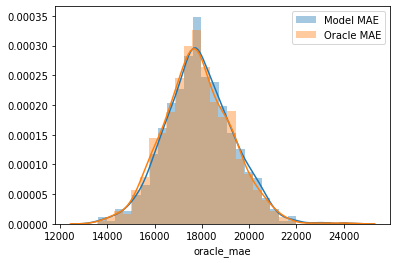

In [119]:
# With the MAE.
ax = sns.distplot(results_df['model_mae'], label = 'Model MAE')
sns.distplot(results_df['oracle_mae'], label = 'Oracle MAE')
ax.legend()

print('Model Mean: ', results_df['model_mae'].mean(),
      '. Oracle mean: ', results_df['oracle_mae'].mean(),
      '. Difference: ', results_df['model_mae'].mean() - results_df['oracle_mae'].mean(),
      '. Difference as % of oracle: ', (results_df['model_mae'].mean() - results_df['oracle_mae'].mean()) / results_df['oracle_mae'].mean())

Now, to perform the same experiment, with cauchy noise.

In [120]:
# Results with Gaussian noise.
results = []

for i in range(1000):
    df = simulate_multivariate_ols(500)
    df['cauchy_noise'] = generate_cauchy_noise(500, df['fX'].values)
    df['Y'] = df['fX'] + df['cauchy_noise']

    train_df = df[df.index <= 399]
    test_df = df[df.index >= 400]

    tempX = sm.add_constant(train_df[['X1', 'X2', 'X3']].values)
    model = sm.OLS(train_df['Y'].values, tempX)
    fitted_model = model.fit()
    testX = sm.add_constant(test_df[['X1', 'X2', 'X3']].values)
    modelY = fitted_model.predict(testX)
    model_mse = np.mean(np.square(modelY - test_df['Y'].values))
    oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
    model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
    oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))
    results.append([model_mse, oracle_mse, model_mae, oracle_mae])

results_df = pd.DataFrame(results, columns=['model_mse', 'oracle_mse', 'model_mae', 'oracle_mae'])

Model Mean:  4913305365189358.0 . Oracle mean:  4908177002608989.0 . Difference:  5128362580369.0 . Difference as % of oracle:  0.0010448609692851275


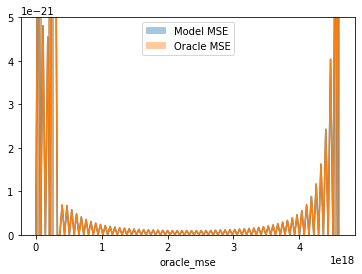

In [127]:
# Plotting the results of Cauchy noise and MSE.
ax = sns.distplot(results_df['model_mse'], label = 'Model MSE')
sns.distplot(results_df['oracle_mse'], label = 'Oracle MSE')
ax.legend()
ax.set_ylim(0, 0.5e-20)

print('Model Mean: ', results_df['model_mse'].mean(),
      '. Oracle mean: ', results_df['oracle_mse'].mean(),
      '. Difference: ', results_df['model_mse'].mean() - results_df['oracle_mse'].mean(),
      '. Difference as % of oracle: ', (results_df['model_mse'].mean() - results_df['oracle_mse'].mean()) / results_df['oracle_mse'].mean())

Model Mean:  585242.1385275874 . Oracle mean:  413840.2029281384 . Difference:  171401.93559944903 . Difference as % of oracle:  0.4141742015074651


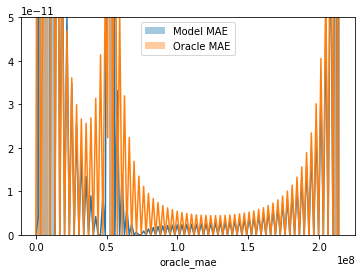

In [129]:
# Plotting the results of Cauchy noise and MAE.
ax = sns.distplot(results_df['model_mae'], label = 'Model MAE')
sns.distplot(results_df['oracle_mae'], label = 'Oracle MAE')
ax.legend()
ax.set_ylim(0, 0.5e-10)

print('Model Mean: ', results_df['model_mae'].mean(),
      '. Oracle mean: ', results_df['oracle_mae'].mean(),
      '. Difference: ', results_df['model_mae'].mean() - results_df['oracle_mae'].mean(),
      '. Difference as % of oracle: ', (results_df['model_mae'].mean() - results_df['oracle_mae'].mean()) / results_df['oracle_mae'].mean())

With additive Cauchy noise, it's much more difficult to tell the accuracy of the results. The difference in MSE (as % of the oracle MSE) is of the same order of magnitude as it would be for the standard Gaussian noise. However, the difference in MAE is 2 orders of magnitude worse than it would be for standard Gaussian noise. So by that metric, it certainly looks like linear regression (fitted with minimizing MSE) performs much worse under this type of noise. The density plots are pathological and difficult to draw any conclusions from.

Next we look at Student's t-distributions with varying degrees of freedom.

Afterwards, some possibilities:

- Beta distributions with negative skew and high excess kurtosis.
- Pearson distributions with skew and kurtosis of our choice.
- Some simple heteroscedastic errors (like N(0, sigma^2 where sigma depends on x).

In [141]:
# Multivariate model: f(X) = 5.01 + -7.047 * X1 + 6.65 * X2 + 3.71 * X3.
# We'll draw X1 from (-500, 500), X2 from (-300, 300), and X3 from (-1, 1).
# At this stage, the train and test data are still iid.
def simulate_multivariate_ols2(N):
    # Draw N samples.
    X1 = np.random.uniform(-500, 500, N)
    X2 = np.random.uniform(-300, 300, N)
    X3 = np.random.uniform(-1, 1, N)
    fX = 5.01 - 7.047 * X1 + 6.65 * X2 + 3.71 * X3
    data = np.vstack([X1, X2, X3, fX]).T
    df = pd.DataFrame(data, columns=['X1', 'X2', 'X3', 'fX'])
    return df


def simulate_univariate_ols(N):
    # Draw N samples.
    X1 = np.random.uniform(-500, 500, N)
    fX = 5.01 - 7.047 * X1
    data = np.vstack([X1, fX]).T
    df = pd.DataFrame(data, columns = ['X1', 'fX'])
    return df


def generate_t2_noise(N, Y):
    """Draw N samples from Student's t with DoF = 2.
    
    This has mean 0 but undefined variance.
    """
    # Scale parameter that would make Gaussian error give
    # 0.5% R^2.
    scale = np.sqrt(0.995 / 0.005 * np.var(Y))
    noise = scale * np.random.standard_t(2, size = N) 
    return noise

In [426]:
# To get a sense for how the errors look like, use a univariate ols.
df = simulate_univariate_ols(1000)
df['noise'] = generate_t2_noise(1000, df['fX'])
df['Y'] = df['fX'] + df['noise']

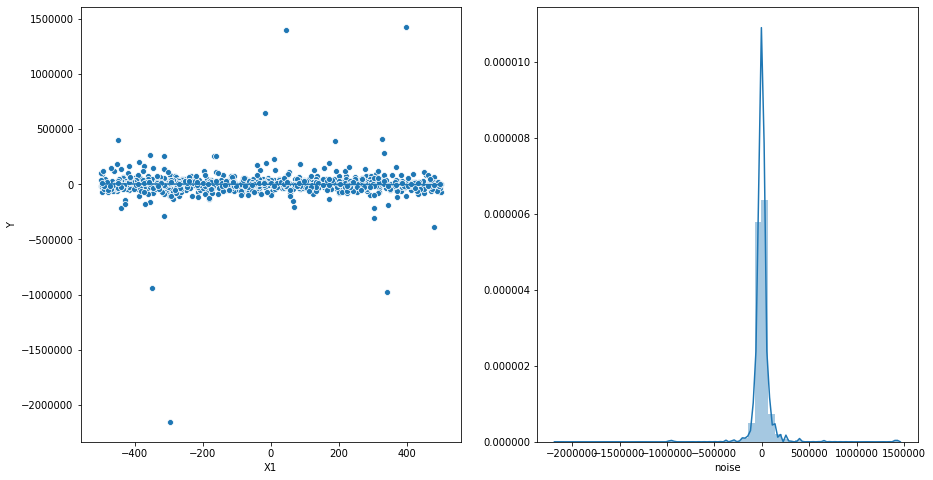

In [427]:
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
sns.lineplot(x = 'X1', y = 'fX', data = df, ax = ax[0])
sns.scatterplot(x = 'X1', y = 'Y', data = df, ax = ax[0])
sns.distplot(df['noise'], ax = ax[1])

In [145]:
# Try fitting a ton of regression lines and see what they look like.
results = []
for i in range(1000):
    df = simulate_univariate_ols(500)
    df['noise'] = generate_t2_noise(500, df['fX'].values)
    df['Y'] = df['fX'] + df['noise']

    train_df = df[df.index <= 399]
    test_df = df[df.index >= 400]

    tempX = sm.add_constant(train_df[['X1']].values)
    model = sm.OLS(train_df['Y'].values, tempX)
    fitted_model = model.fit()
    testX = sm.add_constant(test_df[['X1']].values)
    modelY = fitted_model.predict(testX)
    model_mse = np.mean(np.square(modelY - test_df['Y'].values))
    oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
    model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
    oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))
    results.append(np.concatenate((fitted_model.params, [model_mse, oracle_mse, model_mae, oracle_mae])))
    
results_df = pd.DataFrame(results, columns=['B0', 'B1', 'Model_MSE', 'Oracle_MSE', 'Model_MAE', 'Oracle_MAE'])

Approximate MLE of intercept:  577.5870452219096 Approximate MLE of b:  0.029130526213881028 Mean of intercept:  112.9204963079979 Mean of b:  -7.013591135820809


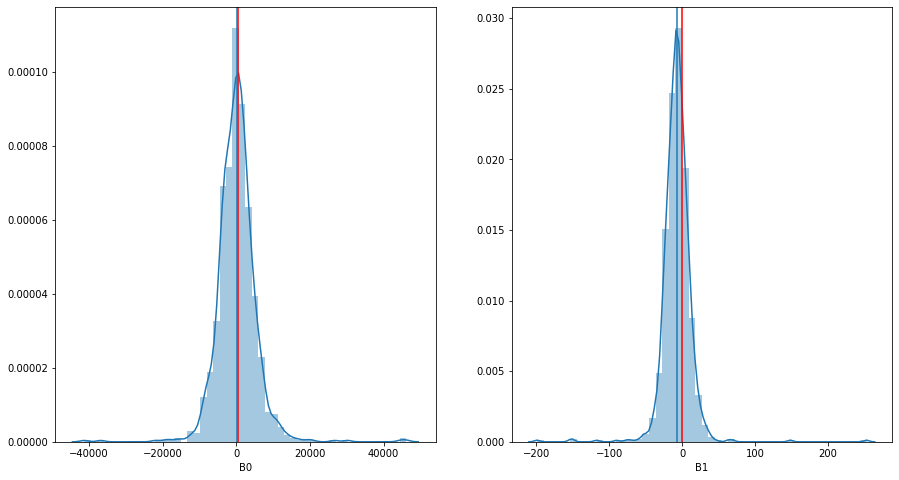

In [155]:
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
sns.distplot(results_df['B0'], ax = ax[0])
b0_density = ax[0].get_lines()[0].get_data()
sns.distplot(results_df['B1'], ax = ax[1])
b1_density = ax[1].get_lines()[0].get_data()

b0_max_idx = np.argmax(b0_density[1])
mle_b0_est = b0_density[0][b0_max_idx]
b1_max_idx = np.argmax(b1_density[1])
mle_b1_est = b1_density[1][b1_max_idx]  # Grid was not granular enough to provide a good estimate.

b0_mean = results_df['B0'].mean()
b1_mean = results_df['B1'].mean()
ax[0].axvline(mle_b0_est, 0, 1, color = 'r')
ax[0].axvline(b0_mean, 0, 1)
ax[1].axvline(mle_b1_est, 0, 1, color = 'r')
ax[1].axvline(b1_mean, 0, 1)

print('Approximate MLE of intercept: ', mle_b0_est,
      'Approximate MLE of b: ', mle_b1_est,
      'Mean of intercept: ', b0_mean,
      'Mean of b: ', b1_mean)

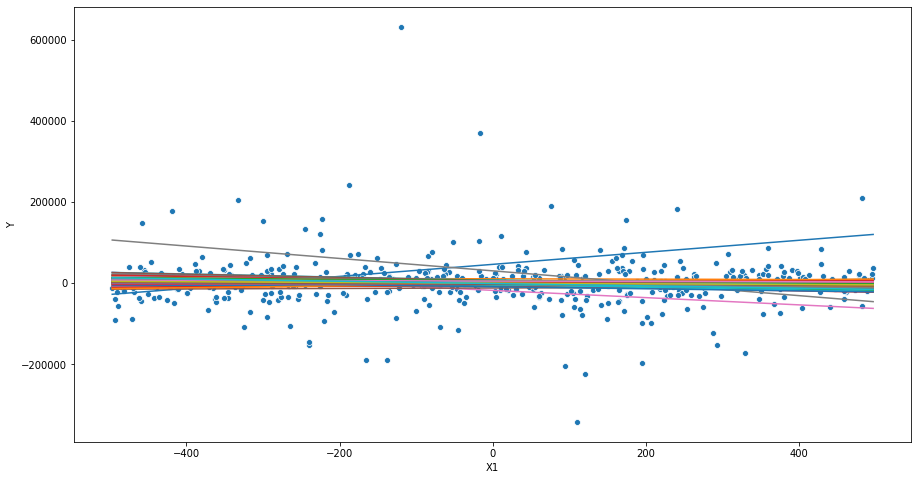

In [161]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.scatterplot(x = 'X1', y = 'Y', data = df, ax = ax)
X = df['X1'].values
for i, row in results_df.iterrows():
    if i % 10 != 0:
        continue
    Y = row['B1'] * X + row['B0']
    sns.lineplot(x = X, y = Y, ax = ax)

Model Mean:  7684116921.07359 . Oracle mean:  7618614156.51286 . Difference:  65502764.56072998 . Difference as % of oracle:  0.008597726990115937


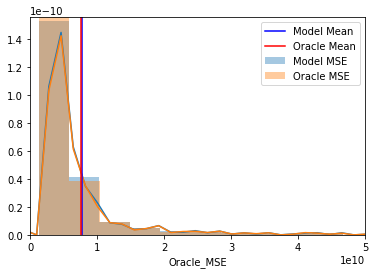

In [169]:
# Plotting the results of t distribution noise and MSE.
ax = sns.distplot(results_df['Model_MSE'], label = 'Model MSE')
sns.distplot(results_df['Oracle_MSE'], label = 'Oracle MSE')

ax.axvline(results_df['Model_MSE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MSE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()
ax.set_xlim(0, 0.5e11)

print('Model Mean: ', results_df['Model_MSE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MSE'].mean(),
      '. Difference: ', results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean()) / results_df['Oracle_MSE'].mean())

Model Mean:  40655.467073713946 . Oracle mean:  40021.06685616636 . Difference:  634.4002175475835 . Difference as % of oracle:  0.015851656824331668


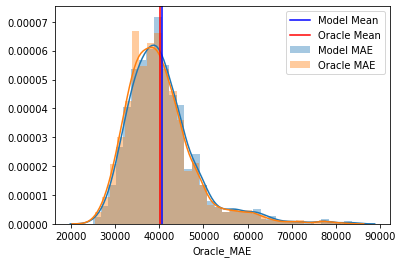

In [171]:
# Plotting the results of t distribution noise and MSE.
ax = sns.distplot(results_df['Model_MAE'], label = 'Model MAE')
sns.distplot(results_df['Oracle_MAE'], label = 'Oracle MAE')

ax.axvline(results_df['Model_MAE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MAE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()

print('Model Mean: ', results_df['Model_MAE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MAE'].mean(),
      '. Difference: ', results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean()) / results_df['Oracle_MAE'].mean())

For the univariate results for the Student's t distributions with 2 DoF, the results look much better than compared to the Cauchy errors.
Now to test the multivariate case.

In [172]:
results = []
for i in range(1000):
    df = simulate_multivariate_ols2(500)
    df['noise'] = generate_t2_noise(500, df['fX'].values)
    df['Y'] = df['fX'] + df['noise']

    train_df = df[df.index <= 399]
    test_df = df[df.index >= 400]

    tempX = sm.add_constant(train_df[['X1']].values)
    model = sm.OLS(train_df['Y'].values, tempX)
    fitted_model = model.fit()
    testX = sm.add_constant(test_df[['X1']].values)
    modelY = fitted_model.predict(testX)
    model_mse = np.mean(np.square(modelY - test_df['Y'].values))
    oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
    model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
    oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))
    results.append([model_mse, oracle_mse, model_mae, oracle_mae])
    
results_df = pd.DataFrame(results, columns=['Model_MSE', 'Oracle_MSE', 'Model_MAE', 'Oracle_MAE'])

Model Mean:  18541060524.13279 . Oracle mean:  18485069757.46832 . Difference:  55990766.66447067 . Difference as % of oracle:  0.0030289724301337485


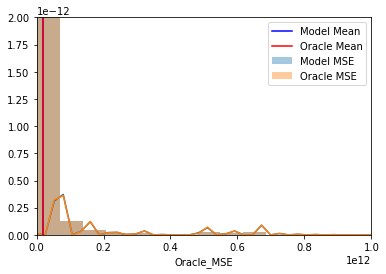

In [180]:
# Plotting the results of t distribution noise and MSE.
ax = sns.distplot(results_df['Model_MSE'], label = 'Model MSE')
sns.distplot(results_df['Oracle_MSE'], label = 'Oracle MSE')

ax.axvline(results_df['Model_MSE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MSE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()
ax.set_xlim(0, 1e12)
ax.set_ylim(0, 0.2e-11)

print('Model Mean: ', results_df['Model_MSE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MSE'].mean(),
      '. Difference: ', results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean()) / results_df['Oracle_MSE'].mean())

Model Mean:  47508.085996699796 . Oracle mean:  46839.58070392085 . Difference:  668.5052927789438 . Difference as % of oracle:  0.014272230509590889


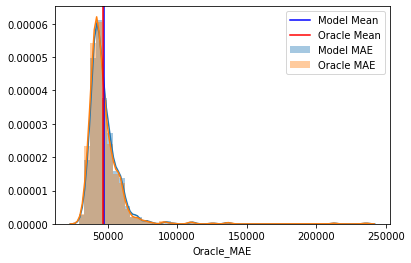

In [181]:
# Plotting the results of t distribution noise and MSE.
ax = sns.distplot(results_df['Model_MAE'], label = 'Model MAE')
sns.distplot(results_df['Oracle_MAE'], label = 'Oracle MAE')

ax.axvline(results_df['Model_MAE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MAE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()

print('Model Mean: ', results_df['Model_MAE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MAE'].mean(),
      '. Difference: ', results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean()) / results_df['Oracle_MAE'].mean())

Results for the multivariate case are similar. It seems that the t distribution doesn't affect things too much--the linear model can still generate good results. I should increase the number of independent variables we have for the more complex algorithms (bump up to 10 covariates). I will increase the number of independent variables to 10.

To create some correlation between the independent variables, I'll generate samples from a 10-D multivariate normal with some covariance matrix and mean 0. Then, applying the cdf to each dimension should yield a 10-D uniform distribution.

In [277]:
# Generate 10 correlated random variables, with pairwise
# correlation in (-0.5, 0.5).

# After 500 iterations, the largest correlation we see is roughly 0.40,
# for the given parameters. Since the correlations aren't too high,
# the original correlations not being preserved due to the nonlinear
# transform isn't too large of a worry.

# Use the following coefficients for the 10 random variables:
# [-430, 250], [-136, 446], [-251, 1000], [-600, 860], [-300, 60],
# [272, 744], [-48, -10], [-30, 26], [0.16, 2], [0.3, 0.21]
N = 500
max_corr = []
for it in range(N):
    corrmat = np.ones((10, 10))
    corrs = np.random.uniform(-0.5, 0.5, 45)
    ctr = 0
    for i in range(10):
        for j in range(i+1, 10):
            corrmat[i, j] = corrs[ctr]
            ctr += 1
    for i in range(10):
        for j in range(i+1, 10):
            corrmat[j, i] = corrmat[i, j]
    covmat = corrmat * corrmat.T
    diag = np.ones(10)
    rvs = stats.multivariate_normal(mean=np.zeros(10), cov=covmat, allow_singular=False).rvs(size = 500)
    uniform_samples = stats.norm.cdf(rvs)
    max_corr.append(np.max(np.abs(np.corrcoef(uniform_samples.T) - np.diag(np.diag(np.ones((10, 10)))))))

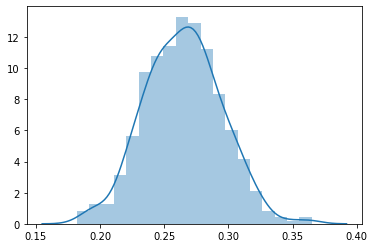

In [278]:
sns.distplot(max_corr)

In [291]:
# Generate 10 correlated random variables, with pairwise
# correlation in (-0.5, 0.5).

# Use the following coefficients for the 10 random variables:
# [-430, 250], [-136, 446], [-48, -10], [-600, 860], [-300, 60],
# [272, 744], [-251, 1000], [-30, 26], [0.16, 2], [0.21, 0.3].

# To scale U(0,1) samples to U(a,b), we need to transform a sample
# z by (b-a)z + a.
scales = {
    1: [-430, 250],
    2: [-136, 446],
    3: [-48, -10],
    4: [-600, 860],
    5: [-300, 60],
    6: [272, 744],
    7: [-251, 1000],
    8: [-30, 26],
    9: [0.16, 2],
    10: [0.21, 0.3],
}


def generate_rvs(D = 10, corr_seed_bounds = [-0.5, 0.5], N = 500, scales = scales):
    """Generate U(0,1) random variables with correlation.
    
    The function works by generating N samples from a D dimensional MVN with
    correlation matrix. The matrix is generated by sampling from the corr_seed_bounds
    until the matrix is filled, then multiplying it by its transpose.
    
    Parameters
    ----------
    D: integer
        The number of random variables to generate.
    corr_seed_bounds: length 2 list of reals in [0,1]
        The bounds to seed the correlation matrix with.
    N: integer
        The number of samples to generate for each random variable.
    scales: dictionary, with keys 1-D, values are length 2 lists of reals.
        The [low, high] scale for each random variable.
        
    Returns
    -------
    NxD matrix
        A matrix where each column is a collection of N observations for
        one of the random variables.
    """
    # Generate 10 U(0,1) random variables with correlation.
    # Based on the above simulation, the correlation should not exceed 50%
    # in general.
    corrmat = np.ones((D, D))
    corrs = np.random.uniform(corr_seed_bounds[0], corr_seed_bounds[1], 45)
    ctr = 0
    for i in range(10):
        for j in range(i+1, D):
            corrmat[i, j] = corrs[ctr]
            ctr += 1
    for i in range(D):
        for j in range(i+1, D):
            corrmat[j, i] = corrmat[i, j]
    covmat = corrmat * corrmat.T
    rvs = stats.multivariate_normal(mean=np.zeros(D), cov=covmat, allow_singular=False).rvs(size = N)
    uniform_samples = stats.norm.cdf(rvs)

    # Scale the samples:
    for i in scales:
        idx = i - 1
        uniform_samples[:, idx] = scales[i][0] + (
            scales[i][1] - scales[i][0]) * uniform_samples[:, idx]
        
    return uniform_samples

In [308]:
# Simulation. The true model will be
# Y = 34.21 * X1 - 55.36 * X2 + 22.59 * X3 + 69.9 * X4 - 87.96 * X5 + 
# 7.7 * X6 + 3.77 * X7 + 6.71 * X8 - 1.73 * X9 + 5.53 * X10.

def simulate_10var_linear(N):
    samples = generate_rvs(D = 10, N = N)
    fX = (89.237 + 34.21 * samples[:, 0] - 55.36 * samples[:, 1] + 22.59 * samples[:, 2] +
          69.9 * samples[:, 3] - 87.96 * samples[:, 4] + 7.7 * samples[:, 5] + 3.77 * samples[:, 6] +
          6.71 * samples[:, 7] - 1.73 * samples[:, 8] + 5.53 * samples[:, 9])
    fX = fX.reshape((fX.shape[0], 1))
    data = np.hstack([samples, fX])
    columns = ['X{}'.format(i) for i in range(1, 11)] + ['fX']
    df = pd.DataFrame(data, columns=columns)
    return df

In [440]:
# Generate the data with Gaussian noise s/t R^2 is 0.05% 

results = []
features = ['X{}'.format(i) for i in range(1, 11)]
for i in range(1000):
    df = simulate_10var_linear(500)
    df['noise'] = generate_gaussian_noise(500, df['fX'].values)
    df['Y'] = df['fX'] + df['noise']

    train_df = df[df.index <= 399]
    test_df = df[df.index >= 400]

    tempX = sm.add_constant(train_df[features].values)
    model = sm.OLS(train_df['Y'].values, tempX)
    fitted_model = model.fit()
    testX = sm.add_constant(test_df[features].values)
    modelY = fitted_model.predict(testX)
    model_mse = np.mean(np.square(modelY - test_df['Y'].values))
    oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
    model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
    oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))
    results.append([model_mse, oracle_mse, model_mae, oracle_mae])
    
results_df = pd.DataFrame(results, columns=['Model_MSE', 'Oracle_MSE', 'Model_MAE', 'Oracle_MAE'])

Model Mean:  208887180157.05487 . Oracle mean:  203074054419.6284 . Difference:  5813125737.426483 . Difference as % of oracle:  0.02862564473851667


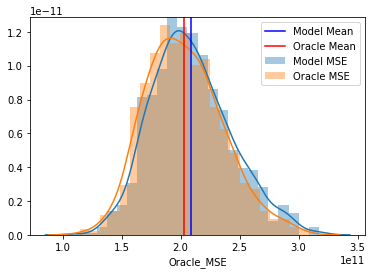

In [441]:
# Plotting the results of Gaussian noise and MSE.
ax = sns.distplot(results_df['Model_MSE'], label = 'Model MSE')
sns.distplot(results_df['Oracle_MSE'], label = 'Oracle MSE')

ax.axvline(results_df['Model_MSE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MSE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()

print('Model Mean: ', results_df['Model_MSE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MSE'].mean(),
      '. Difference: ', results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean()) / results_df['Oracle_MSE'].mean())

Model Mean:  364214.7583340287 . Oracle mean:  359057.72255970567 . Difference:  5157.035774323042 . Difference as % of oracle:  0.014362692821529573


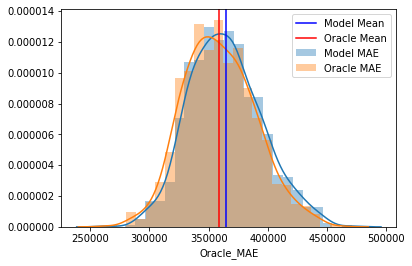

In [442]:
# Plotting the results of Gaussian noise and MAE.
ax = sns.distplot(results_df['Model_MAE'], label = 'Model MAE')
sns.distplot(results_df['Oracle_MAE'], label = 'Oracle MAE')

ax.axvline(results_df['Model_MAE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MAE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()

print('Model Mean: ', results_df['Model_MAE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MAE'].mean(),
      '. Difference: ', results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean()) / results_df['Oracle_MAE'].mean())

With Gaussian noise, even when the noise is large (s/t $R^2 < 0.005$), the linear regression performs well on the 10-D multivariate
linear model, when the true model is linear. As expected, the mean error of the model is above that of the oracle error, but the
difference is small (~2.9% of the oracle error for MSE and 1.4% of the oracle error for MAE). Interestingly, this is worse than
the error differential with just 1 variable. It's possible that including the other variables ended up helping the oracle model
more than it did the linear regression.

In [434]:
# Generate the data with Cauchy noise with scaling equivalent to the Gaussian noise.

results = []
features = ['X{}'.format(i) for i in range(1, 11)]
for i in range(1000):
    df = simulate_10var_linear(500)
    df['noise'] = generate_cauchy_noise(500, df['fX'].values)
    df['Y'] = df['fX'] + df['noise']

    train_df = df[df.index <= 399]
    test_df = df[df.index >= 400]

    tempX = sm.add_constant(train_df[features].values)
    model = sm.OLS(train_df['Y'].values, tempX)
    fitted_model = model.fit()
    testX = sm.add_constant(test_df[features].values)
    modelY = fitted_model.predict(testX)
    model_mse = np.mean(np.square(modelY - test_df['Y'].values))
    oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
    model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
    oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))
    results.append([model_mse, oracle_mse, model_mae, oracle_mae])
    
results_df = pd.DataFrame(results, columns=['Model_MSE', 'Oracle_MSE', 'Model_MAE', 'Oracle_MAE'])

Model Mean:  1.1155741298248174e+17 . Oracle mean:  1.110714496728213e+17 . Difference:  485963309660448.0 . Difference as % of oracle:  0.004375231538725123


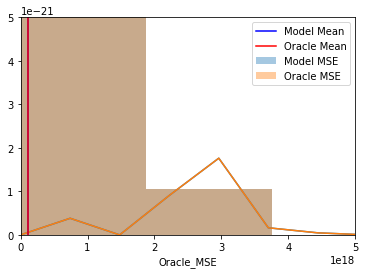

In [437]:
# Plotting the results of Cauchy noise and MSE.
ax = sns.distplot(results_df['Model_MSE'], label = 'Model MSE')
sns.distplot(results_df['Oracle_MSE'], label = 'Oracle MSE')

ax.axvline(results_df['Model_MSE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MSE'].mean(), color = 'r', label = 'Oracle Mean')
ax.legend()

ax.set_xlim([0, 0.5e19])
ax.set_ylim([0, 0.5e-20])

print('Model Mean: ', results_df['Model_MSE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MSE'].mean(),
      '. Difference: ', results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean()) / results_df['Oracle_MSE'].mean())

Model interval:  -44318925065851.22 44318941952238.67
Oracle interval:  -34949631359850.926 34949640249590.113
Model Mean:  8443193.723340495 . Oracle mean:  4444869.593165064 . Difference:  3998324.1301754303 . Difference as % of oracle:  0.8995368809748


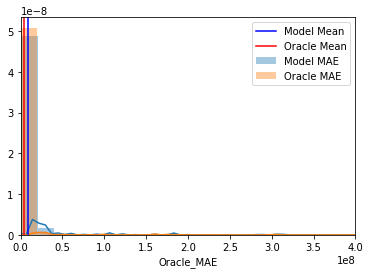

In [439]:
# Plotting the results of Cauchy noise and MAE.
ax = sns.distplot(results_df['Model_MAE'], label = 'Model MAE')
sns.distplot(results_df['Oracle_MAE'], label = 'Oracle MAE')

ax.axvline(results_df['Model_MAE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MAE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()
ax.set_xlim([0, 0.4e9])

# Calculate a rough estimate of CIs for the mean for this plot in particular because the
# discrepancy is so large?
model_interval_width = np.var(results_df['Model_MAE'], ddof=1) / np.sqrt(results_df['Model_MAE'].values.shape[0])
oracle_interval_width = np.var(results_df['Oracle_MAE'], ddof=1) / np.sqrt(results_df['Oracle_MAE'].values.shape[0])

print('Model interval: ', results_df['Model_MAE'].mean() - model_interval_width, results_df['Model_MAE'].mean() + model_interval_width)
print('Oracle interval: ', results_df['Oracle_MAE'].mean() - oracle_interval_width, results_df['Oracle_MAE'].mean() + oracle_interval_width)

print('Model Mean: ', results_df['Model_MAE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MAE'].mean(),
      '. Difference: ', results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean()) / results_df['Oracle_MAE'].mean())

With Cauchy error, we can see that the MSE error still performs pretty well, around 1% difference compared to oracle MSE, but if we look at MAE, we perform much worse than the oracle does--the difference is 89% of the oracle error which is not good.

In [443]:
# Generate the data with Student's t (DoF = 2) noise with scaling equivalent to the Gaussian noise.

results = []
features = ['X{}'.format(i) for i in range(1, 11)]
for i in range(1000):
    df = simulate_10var_linear(500)
    df['noise'] = generate_t2_noise(500, df['fX'].values)
    df['Y'] = df['fX'] + df['noise']

    train_df = df[df.index <= 399]
    test_df = df[df.index >= 400]

    tempX = sm.add_constant(train_df[features].values)
    model = sm.OLS(train_df['Y'].values, tempX)
    fitted_model = model.fit()
    testX = sm.add_constant(test_df[features].values)
    modelY = fitted_model.predict(testX)
    model_mse = np.mean(np.square(modelY - test_df['Y'].values))
    oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
    model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
    oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))
    results.append([model_mse, oracle_mse, model_mae, oracle_mae])
    
results_df = pd.DataFrame(results, columns=['Model_MSE', 'Oracle_MSE', 'Model_MAE', 'Oracle_MAE'])

Model Mean:  3365307494677.7256 . Oracle mean:  3286997581332.727 . Difference:  78309913344.99854 . Difference as % of oracle:  0.02382414693266901


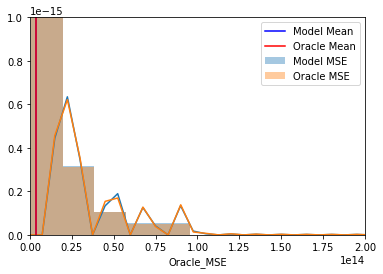

In [446]:
# Plotting the results of Student's t noise and MSE.
ax = sns.distplot(results_df['Model_MSE'], label = 'Model MSE')
sns.distplot(results_df['Oracle_MSE'], label = 'Oracle MSE')

ax.axvline(results_df['Model_MSE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MSE'].mean(), color = 'r', label = 'Oracle Mean')
ax.legend()

ax.set_xlim([0, 0.2e15])
ax.set_ylim([0, 0.1e-14])

print('Model Mean: ', results_df['Model_MSE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MSE'].mean(),
      '. Difference: ', results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean()) / results_df['Oracle_MSE'].mean())

Model Mean:  683340.6870872643 . Oracle mean:  638570.3899877456 . Difference:  44770.297099518706 . Difference as % of oracle:  0.07011019897176546


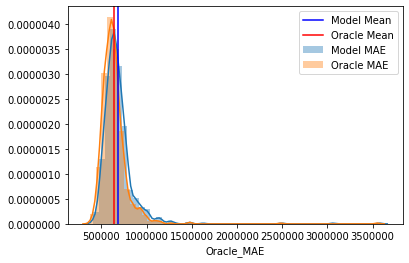

In [447]:
# Plotting the results of Student's t (DoF = 2) noise and MAE.
ax = sns.distplot(results_df['Model_MAE'], label = 'Model MAE')
sns.distplot(results_df['Oracle_MAE'], label = 'Oracle MAE')

ax.axvline(results_df['Model_MAE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MAE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()
print('Model Mean: ', results_df['Model_MAE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MAE'].mean(),
      '. Difference: ', results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean()) / results_df['Oracle_MAE'].mean())

The errors for the Student's t distribution with 2 degrees of freedom are more well-behaved than the Cauchy errors, in particular for the MAE. The difference as a percentage of the oracle error is 7%, which, while large, is much less than the Cauchy distribution's massive 89% differential.

Now to do some investigation on the behavior of the GEV (Generalized Extreme Value) distribution. The high-level idea is to gain a better understanding of how error distributions with high skew and kurtosis.

In [407]:
# First, try with univariate function.
df = simulate_univariate_ols(1000)

In [413]:
def generate_skew_normal_errors(skew, N, Y):
    scale = np.sqrt(0.995 / 0.005 * np.var(Y))
    # Center to have mean 0.
    loc = -scale * skew / np.sqrt(np.square(skew) + 1) * np.sqrt(2 / np.pi)
    errors = stats.skewnorm(a = skew, loc = loc, scale = scale).rvs(N)
    return errors

In [411]:
rvs = generate_skew_normal_errors(-10, 1000, df['fX'])
df['noise'] = rvs
df['Y'] = df['fX'] + df['noise']

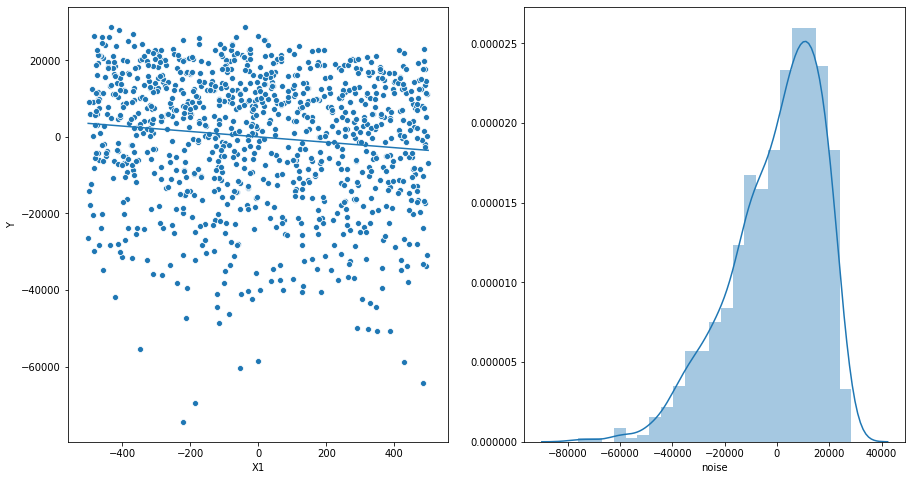

In [412]:
# To get a sense how the errors look like, use a univariate OLS.

fig, ax = plt.subplots(1, 2, figsize = (15, 8))
sns.lineplot(x = 'X1', y = 'fX', data = df, ax = ax[0])
sns.scatterplot(x = 'X1', y = 'Y', data = df, ax = ax[0])
sns.distplot(df['noise'], ax = ax[1])

In [415]:
# Try fitting a ton of regression lines and seeing what the parameter estimates look like,
# as well as the actual lines themselves, and the errors they have.
# Try fitting a ton of regression lines and see what they look like.
results = []
for i in range(1000):
    df = simulate_univariate_ols(500)
    df['noise'] = generate_skew_normal_errors(-10, 500, df['fX'].values)
    df['Y'] = df['fX'] + df['noise']

    train_df = df[df.index <= 399]
    test_df = df[df.index >= 400]

    tempX = sm.add_constant(train_df[['X1']].values)
    model = sm.OLS(train_df['Y'].values, tempX)
    fitted_model = model.fit()
    testX = sm.add_constant(test_df[['X1']].values)
    modelY = fitted_model.predict(testX)
    model_mse = np.mean(np.square(modelY - test_df['Y'].values))
    oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
    model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
    oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))
    results.append(np.concatenate((fitted_model.params, [model_mse, oracle_mse, model_mae, oracle_mae])))
    
results_df = pd.DataFrame(results, columns=['B0', 'B1', 'Model_MSE', 'Oracle_MSE', 'Model_MAE', 'Oracle_MAE'])

Approximate MLE of intercept:  -74.7064161465205 Approximate MLE of b:  0.12386987148498904 Mean of intercept:  -24.210072426054083 Mean of b:  -7.099507530612065


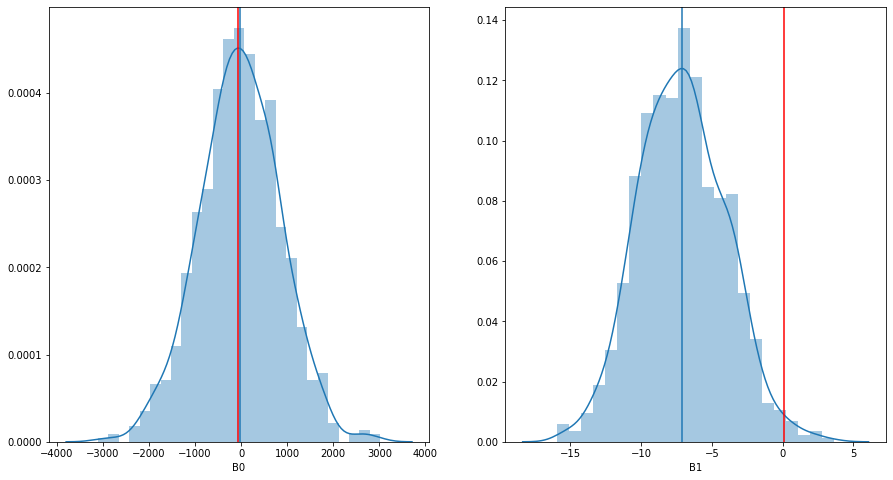

In [416]:
# Plot the distribution of parameter estimates of the OLS.
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
sns.distplot(results_df['B0'], ax = ax[0])
b0_density = ax[0].get_lines()[0].get_data()
sns.distplot(results_df['B1'], ax = ax[1])
b1_density = ax[1].get_lines()[0].get_data()

b0_max_idx = np.argmax(b0_density[1])
mle_b0_est = b0_density[0][b0_max_idx]
b1_max_idx = np.argmax(b1_density[1])
mle_b1_est = b1_density[1][b1_max_idx]

b0_mean = results_df['B0'].mean()
b1_mean = results_df['B1'].mean()
ax[0].axvline(mle_b0_est, 0, 1, color = 'r')
ax[0].axvline(b0_mean, 0, 1)
ax[1].axvline(mle_b1_est, 0, 1, color = 'r')
ax[1].axvline(b1_mean, 0, 1)

print('Approximate MLE of intercept: ', mle_b0_est,
      'Approximate MLE of b: ', mle_b1_est,
      'Mean of intercept: ', b0_mean,
      'Mean of b: ', b1_mean)

Looks like the regression still does a pretty good job of getting the correct slope, though again the intercept is off.

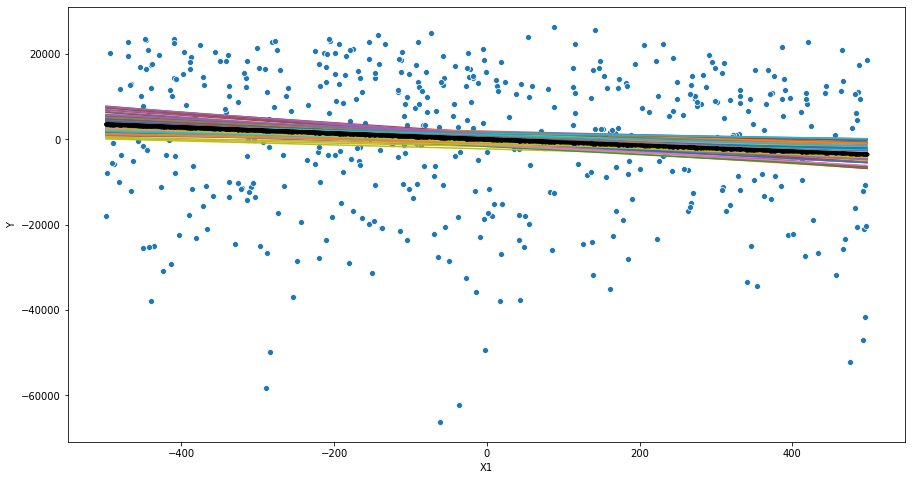

In [420]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.scatterplot(x = 'X1', y = 'Y', data = df, ax = ax)
X = df['X1'].values
for i, row in results_df.iterrows():
    if i % 10 != 0:
        continue
    Y = row['B1'] * X + row['B0']
    sns.lineplot(x = X, y = Y, ax = ax)
    
# The true line:
ax.plot(df['X1'], df['fX'], '.-k', linewidth = 4)

Model Mean:  306513637.221305 . Oracle mean:  304784436.20991075 . Difference:  1729201.0113942623 . Difference as % of oracle:  0.005673521367749006


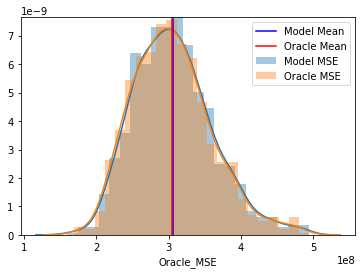

In [421]:
# Now, plotting the actual errors:
# Plotting the results of skew normal noise and MSE.
ax = sns.distplot(results_df['Model_MSE'], label = 'Model MSE')
sns.distplot(results_df['Oracle_MSE'], label = 'Oracle MSE')

ax.axvline(results_df['Model_MSE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MSE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()

print('Model Mean: ', results_df['Model_MSE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MSE'].mean(),
      '. Difference: ', results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean()) / results_df['Oracle_MSE'].mean())

Model Mean:  13971.720885225877 . Oracle mean:  13931.941654730927 . Difference:  39.77923049495075 . Difference as % of oracle:  0.0028552538821064294


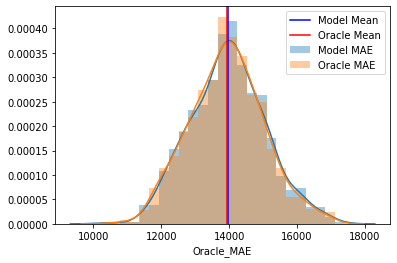

In [422]:
# Plotting the results of t distribution noise and MSE.
ax = sns.distplot(results_df['Model_MAE'], label = 'Model MAE')
sns.distplot(results_df['Oracle_MAE'], label = 'Oracle MAE')

ax.axvline(results_df['Model_MAE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MAE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()

print('Model Mean: ', results_df['Model_MAE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MAE'].mean(),
      '. Difference: ', results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean()) / results_df['Oracle_MAE'].mean())

In [448]:
# Scale up to multivariate OLS.
results = []
features = ['X{}'.format(i) for i in range(1, 11)]
for i in range(1000):
    df = simulate_10var_linear(500)
    df['noise'] = generate_skew_normal_errors(-10, 500, df['fX'].values)
    df['Y'] = df['fX'] + df['noise']
    
    train_df = df[df.index <= 399]
    test_df = df[df.index >= 400]
    
    tempX = sm.add_constant(train_df[features].values)
    model = sm.OLS(train_df['Y'].values, tempX)
    fitted_model = model.fit()
    testX = sm.add_constant(test_df[features].values)
    modelY = fitted_model.predict(testX)
    model_mse = np.mean(np.square(modelY - test_df['Y'].values))
    oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
    model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
    oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))
    results.append([model_mse, oracle_mse, model_mae, oracle_mae])
    
results_df = pd.DataFrame(results, columns=['Model_MSE', 'Oracle_MSE', 'Model_MAE', 'Oracle_MAE'])

Model Mean:  78111231096.60085 . Oracle mean:  75827376895.2899 . Difference:  2283854201.3109436 . Difference as % of oracle:  0.030119124448478814


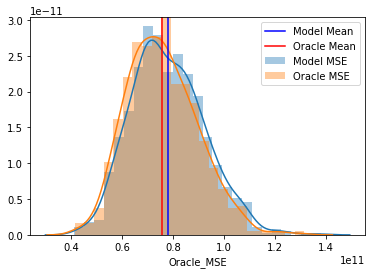

In [449]:
# Plotting the results of skew Gaussian noise and MSE.
ax = sns.distplot(results_df['Model_MSE'], label = 'Model MSE')
sns.distplot(results_df['Oracle_MSE'], label = 'Oracle MSE')

ax.axvline(results_df['Model_MSE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MSE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()

print('Model Mean: ', results_df['Model_MSE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MSE'].mean(),
      '. Difference: ', results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean()) / results_df['Oracle_MSE'].mean())

Model Mean:  222864.58759252058 . Oracle mean:  219867.7956431337 . Difference:  2996.791949386883 . Difference as % of oracle:  0.013629972232272528


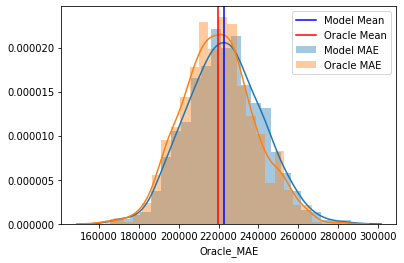

In [450]:
# Plotting the results of skew Gaussian noise and MAE.
ax = sns.distplot(results_df['Model_MAE'], label = 'Model MAE')
sns.distplot(results_df['Oracle_MAE'], label = 'Oracle MAE')

ax.axvline(results_df['Model_MAE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MAE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()

print('Model Mean: ', results_df['Model_MAE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MAE'].mean(),
      '. Difference: ', results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean()) / results_df['Oracle_MAE'].mean())

Performance of the linear regression on data with skew normal errors, assuming each random variable's sample
is drawn uniformly across its range, is on par with performance on Gaussian errors, for both MSE and MAE.

In [451]:
def generate_gev_noise(c, N, Y):
    scale = np.sqrt(0.995 / 0.005 * np.var(Y))
    center = -1 / c * (1 - special.gamma(1 + c))
    noise = stats.genextreme(c = c, loc = center, scale = scale).rvs(size = N)
    return noise

In [452]:
# Use a univariate OLS at first.
df = simulate_univariate_ols(1000)
df['noise'] = generate_gev_noise(2, 1000, df['fX'])
df['Y'] = df['fX'] + df['noise']

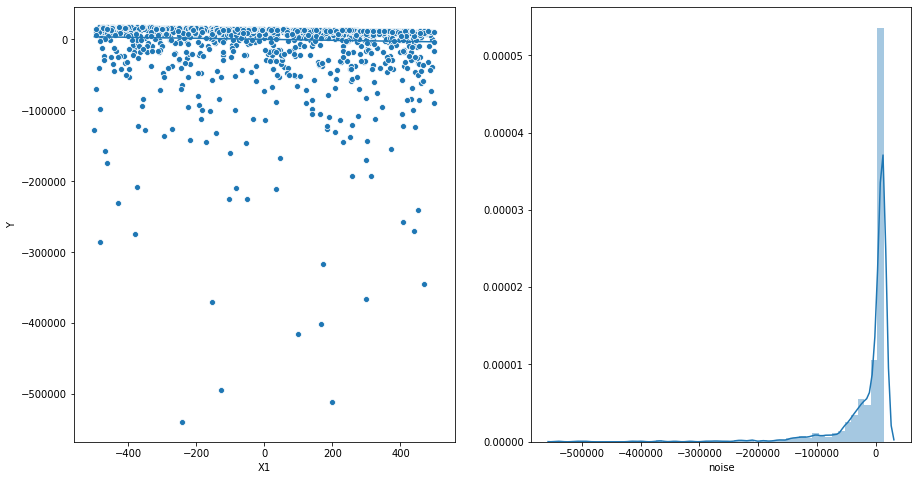

In [453]:
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
sns.lineplot(x = 'X1', y = 'fX', data = df, ax = ax[0])
sns.scatterplot(x = 'X1', y = 'Y', data = df, ax = ax[0])
sns.distplot(df['noise'], ax = ax[1])

In [455]:
# Try fitting a ton of regression lines and see what they look like.
results = []
for i in range(1000):
    df = simulate_univariate_ols(500)
    df['noise'] = generate_gev_noise(2, 500, df['fX'].values)
    df['Y'] = df['fX'] + df['noise']

    train_df = df[df.index <= 399]
    test_df = df[df.index >= 400]

    tempX = sm.add_constant(train_df[['X1']].values)
    model = sm.OLS(train_df['Y'].values, tempX)
    fitted_model = model.fit()
    testX = sm.add_constant(test_df[['X1']].values)
    modelY = fitted_model.predict(testX)
    model_mse = np.mean(np.square(modelY - test_df['Y'].values))
    oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
    model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
    oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))
    results.append(np.concatenate((fitted_model.params, [model_mse, oracle_mse, model_mae, oracle_mae])))
    
results_df = pd.DataFrame(results, columns=['B0', 'B1', 'Model_MSE', 'Oracle_MSE', 'Model_MAE', 'Oracle_MAE'])

Approximate MLE of intercept:  -13882.75467133347 Approximate MLE of b:  0.03572044946391009 Mean of intercept:  -14425.956406817813 Mean of b:  -6.997254767959648


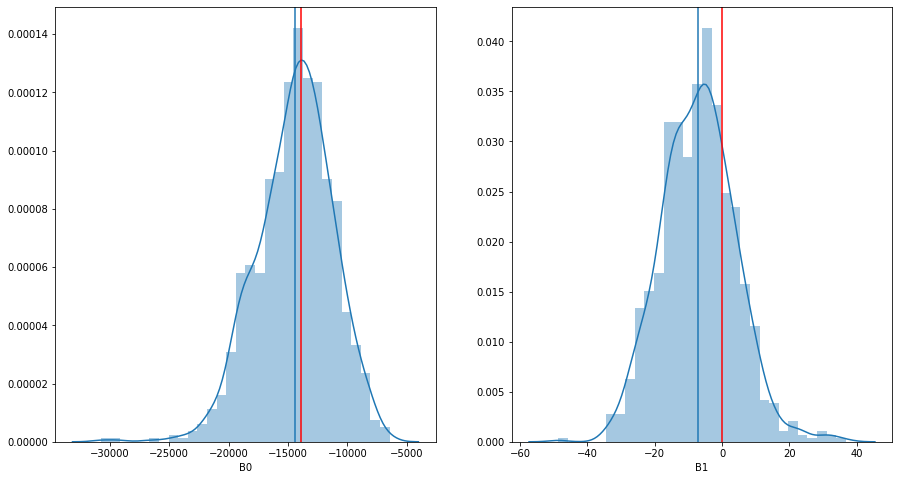

In [456]:
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
sns.distplot(results_df['B0'], ax = ax[0])
b0_density = ax[0].get_lines()[0].get_data()
sns.distplot(results_df['B1'], ax = ax[1])
b1_density = ax[1].get_lines()[0].get_data()

b0_max_idx = np.argmax(b0_density[1])
mle_b0_est = b0_density[0][b0_max_idx]
b1_max_idx = np.argmax(b1_density[1])
mle_b1_est = b1_density[1][b1_max_idx]

b0_mean = results_df['B0'].mean()
b1_mean = results_df['B1'].mean()
ax[0].axvline(mle_b0_est, 0, 1, color = 'r')
ax[0].axvline(b0_mean, 0, 1)
ax[1].axvline(mle_b1_est, 0, 1, color = 'r')
ax[1].axvline(b1_mean, 0, 1)

print('Approximate MLE of intercept: ', mle_b0_est,
      'Approximate MLE of b: ', mle_b1_est,
      'Mean of intercept: ', b0_mean,
      'Mean of b: ', b1_mean)

The intercept is way off. Slope is pretty on point.

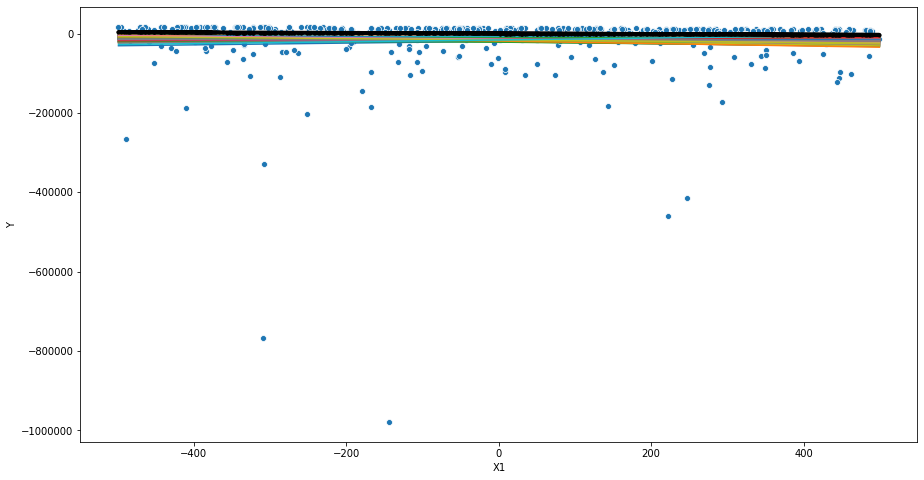

In [457]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.scatterplot(x = 'X1', y = 'Y', data = df, ax = ax)
X = df['X1'].values
for i, row in results_df.iterrows():
    if i % 10 != 0:
        continue
    Y = row['B1'] * X + row['B0']
    sns.lineplot(x = X, y = Y, ax = ax)
    
# The true line:
ax.plot(df['X1'], df['fX'], '.-k', linewidth = 4)

Model Mean:  4185176690.744555 . Oracle mean:  4378040863.646763 . Difference:  -192864172.90220785 . Difference as % of oracle:  -0.04405262054625009


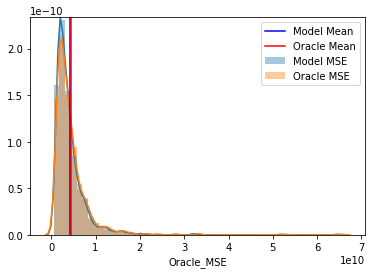

In [458]:
# Plotting the results of GEV distribution noise and MSE.
ax = sns.distplot(results_df['Model_MSE'], label = 'Model MSE')
sns.distplot(results_df['Oracle_MSE'], label = 'Oracle MSE')

ax.axvline(results_df['Model_MSE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MSE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()
# ax.set_xlim(0, 0.5e11)

print('Model Mean: ', results_df['Model_MSE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MSE'].mean(),
      '. Difference: ', results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean()) / results_df['Oracle_MSE'].mean())

Model Mean:  33904.84775799398 . Oracle mean:  27953.79477235409 . Difference:  5951.05298563989 . Difference as % of oracle:  0.21288891308329264


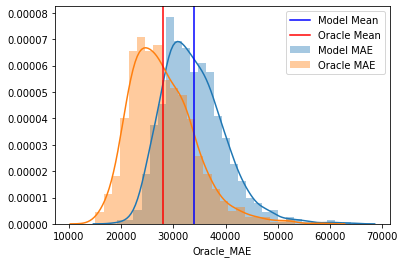

In [459]:
# Plotting the results of GEV distribution noise and MSE.
ax = sns.distplot(results_df['Model_MAE'], label = 'Model MAE')
sns.distplot(results_df['Oracle_MAE'], label = 'Oracle MAE')

ax.axvline(results_df['Model_MAE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MAE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()

print('Model Mean: ', results_df['Model_MAE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MAE'].mean(),
      '. Difference: ', results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean()) / results_df['Oracle_MAE'].mean())

Looking at the errors provides some interesting results. For the MSE, the model actually performs better than the oracle. Does this make
sense? Obviously, no, since the oracle should be the true representation of the model.
What's happening, then? Some possible thoughts/explanations:

- The regression is fitting to the noise, which is why it gets extra explanatory power compared to the oracle.
  In this case, there's predictability to the errors in that large errors are always skewed downwards. This
  consistent trend of negative outliers hurts the MSE a lot, but that means a regression which shifts downwards
  will get less MSE, even if it's away from the true model. I would guess this doesn't happen on the Cauchy
  because the skew is 0, so there are large outliers on both sides.
    - This also explains why the intercept was so off. Since the negative outliers occur uniformly across the
      range of `X1`, the regression adjusts by shifting the intercept down.
  
For the MAE, we can see this hurts the linear regression as it gets pulled down due to trying to minimize the MSE, especially for the
extreme negative values.

In [465]:
# Scale up to multivariate OLS.
# Additionally run a LAD (Least Absolute Deviation) regression to minimize L1 loss.
results = []
features = ['X{}'.format(i) for i in range(1, 11)]
for i in range(1000):
    df = simulate_10var_linear(500)
    df['noise'] = generate_gev_noise(2, 500, df['fX'].values)
    df['Y'] = df['fX'] + df['noise']
    
    train_df = df[df.index <= 399]
    test_df = df[df.index >= 400]
    
    tempX = sm.add_constant(train_df[features].values)
    model = sm.OLS(train_df['Y'].values, tempX)
    robust_model = sm.QuantReg(train_df['Y'].values, tempX)
    fitted_model = model.fit()
    fitted_robust_model = robust_model.fit(q = 0.5)
    testX = sm.add_constant(test_df[features].values)
    modelY = fitted_model.predict(testX)
    robust_modelY = fitted_robust_model.predict(testX)
    model_mse = np.mean(np.square(modelY - test_df['Y'].values))
    robust_mse = np.mean(np.square(robust_modelY - test_df['Y'].values))
    oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
    model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
    robust_mae = np.mean(np.abs(robust_modelY - test_df['Y'].values))
    oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))
    results.append([model_mse, robust_mse, oracle_mse, model_mae, robust_mae, oracle_mae])
    
results_df = pd.DataFrame(results, columns=['Model_MSE', 'Robust_MSE', 'Oracle_MSE', 'Model_MAE', 'Robust_MAE', 'Oracle_MAE'])

/Users/georgeyu/Desktop/Projects/stats3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/Users/georgeyu/Desktop/Projects/stats3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/Users/georgeyu/Desktop/Projects/stats3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/Users/georgeyu/Desktop/Projects/stats3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/Users/georgeyu/Desktop/Projects/stats3/lib/python3.7/site-packages/statsmodels/regression/quant

Model Mean:  1071549169434.2051 . Oracle mean:  1092944183761.044 . Difference:  -21395014326.838867 . Difference as % of oracle:  -0.01957557819029171


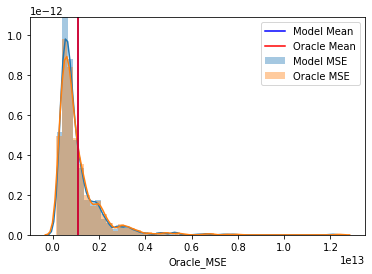

In [466]:
# Plotting the results of GEV noise and MSE.
ax = sns.distplot(results_df['Model_MSE'], label = 'Model MSE')
sns.distplot(results_df['Oracle_MSE'], label = 'Oracle MSE')

ax.axvline(results_df['Model_MSE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MSE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()

print('Model Mean: ', results_df['Model_MSE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MSE'].mean(),
      '. Difference: ', results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MSE'].mean() - results_df['Oracle_MSE'].mean()) / results_df['Oracle_MSE'].mean())

Model Mean:  543101.0416801501 . Oracle mean:  437653.58058191347 . Difference:  105447.46109823661 . Difference as % of oracle:  0.24093818896221855


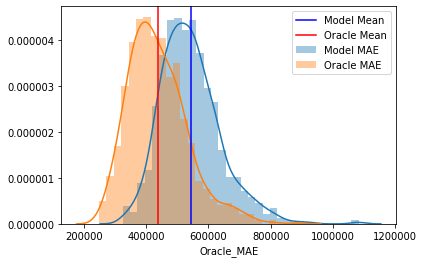

In [467]:
# Plotting the results of GEV noise and MAE.
ax = sns.distplot(results_df['Model_MAE'], label = 'Model MAE')
sns.distplot(results_df['Oracle_MAE'], label = 'Oracle MAE')

ax.axvline(results_df['Model_MAE'].mean(), color = 'b', label = 'Model Mean')
ax.axvline(results_df['Oracle_MAE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()

print('Model Mean: ', results_df['Model_MAE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MAE'].mean(),
      '. Difference: ', results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean(),
      '. Difference as % of oracle: ', (results_df['Model_MAE'].mean() - results_df['Oracle_MAE'].mean()) / results_df['Oracle_MAE'].mean())

Model Mean:  423702.82706547 . Oracle mean:  437653.58058191347 . Difference:  -13950.753516443481 . Difference as % of oracle:  -0.03187624672896373


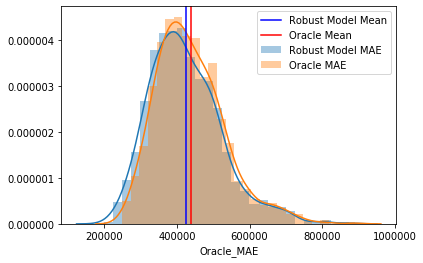

In [468]:
# Check the results of MSE and MAE from the robust regression. First, the MAE:
# Plotting the results of GEV noise and MAE.
ax = sns.distplot(results_df['Robust_MAE'], label = 'Robust Model MAE')
sns.distplot(results_df['Oracle_MAE'], label = 'Oracle MAE')

ax.axvline(results_df['Robust_MAE'].mean(), color = 'b', label = 'Robust Model Mean')
ax.axvline(results_df['Oracle_MAE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()

print('Model Mean: ', results_df['Robust_MAE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MAE'].mean(),
      '. Difference: ', results_df['Robust_MAE'].mean() - results_df['Oracle_MAE'].mean(),
      '. Difference as % of oracle: ', (results_df['Robust_MAE'].mean() - results_df['Oracle_MAE'].mean()) / results_df['Oracle_MAE'].mean())

Model Mean:  1155161451101.2898 . Oracle mean:  1092944183761.044 . Difference:  62217267340.24585 . Difference as % of oracle:  0.056926298949817856


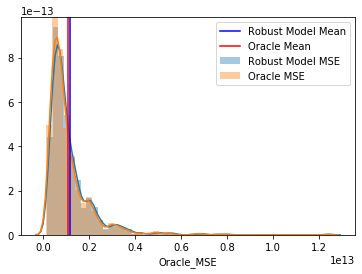

In [469]:
# Check the results of MSE and MAE from the robust regression. Now, the MSE:
# Plotting the results of GEV noise and MAE.
ax = sns.distplot(results_df['Robust_MSE'], label = 'Robust Model MSE')
sns.distplot(results_df['Oracle_MSE'], label = 'Oracle MSE')

ax.axvline(results_df['Robust_MSE'].mean(), color = 'b', label = 'Robust Model Mean')
ax.axvline(results_df['Oracle_MSE'].mean(), color = 'r', label = 'Oracle Mean')

ax.legend()

print('Model Mean: ', results_df['Robust_MSE'].mean(),
      '. Oracle mean: ', results_df['Oracle_MSE'].mean(),
      '. Difference: ', results_df['Robust_MSE'].mean() - results_df['Oracle_MSE'].mean(),
      '. Difference as % of oracle: ', (results_df['Robust_MSE'].mean() - results_df['Oracle_MSE'].mean()) / results_df['Oracle_MSE'].mean())

In [471]:
# What happens when I take samples from outside of the range?
# This is for the estimators with GEV errors. Make sure to store the model
# information.
scales = {
    1: [-430, 250],
    2: [-136, 446],
    3: [-48, -10],
    4: [-600, 860],
    5: [-300, 60],
    6: [272, 744],
    7: [-251, 1000],
    8: [-30, 26],
    9: [0.16, 2],
    10: [0.21, 0.3],
}
samples = {}
for key in scales:
    scale_length = max(abs(scales[key][0]), abs(scales[key][1]))
    shift = np.random.uniform(scale_length, 2 * scale_length)
    switch = np.random.uniform(0, 1)
    if switch <= 0.5:
        samples[key] = np.random.uniform(scales[key][0] - shift, scales[key][1] - shift, size = 500)
    else:
        samples[key] = np.random.uniform(scales[key][0] + shift, scales[key][1] + shift, size = 500)

In [478]:
# Scale up to multivariate OLS.
# Additionally run a LAD (Least Absolute Deviation) regression to minimize L1 loss.
results = []
models = []
robust_models = []
features = ['X{}'.format(i) for i in range(1, 11)]
params = ['B{}'.format(i) for i in range(0, 11)]
for i in range(1000):
    df = simulate_10var_linear(500)
    df['noise'] = generate_gev_noise(2, 500, df['fX'].values)
    df['Y'] = df['fX'] + df['noise']
    
    train_df = df[df.index <= 399]
    test_df = df[df.index >= 400]
    
    tempX = sm.add_constant(train_df[features].values)
    model = sm.OLS(train_df['Y'].values, tempX)
    robust_model = sm.QuantReg(train_df['Y'].values, tempX)
    fitted_model = model.fit()
    fitted_robust_model = robust_model.fit(q = 0.5) 
    testX = sm.add_constant(test_df[features].values)
    modelY = fitted_model.predict(testX)
    robust_modelY = fitted_robust_model.predict(testX)
    model_mse = np.mean(np.square(modelY - test_df['Y'].values))
    robust_mse = np.mean(np.square(robust_modelY - test_df['Y'].values))
    oracle_mse = np.mean(np.square(test_df['fX'].values - test_df['Y'].values))
    model_mae = np.mean(np.abs(modelY - test_df['Y'].values))
    robust_mae = np.mean(np.abs(robust_modelY - test_df['Y'].values))
    oracle_mae = np.mean(np.abs(test_df['fX'] - test_df['Y'].values))
    results.append([model_mse, robust_mse, oracle_mse, model_mae, robust_mae, oracle_mae])
    models.append(fitted_model.params)
    robust_models.append(fitted_robust_model.params)
    
results_df = pd.DataFrame(results, columns=['Model_MSE', 'Robust_MSE', 'Oracle_MSE', 'Model_MAE', 'Robust_MAE', 'Oracle_MAE'])
models_df = pd.DataFrame(models, columns = params)
robust_models_df = pd.DataFrame(robust_models, columns = params)

/Users/georgeyu/Desktop/Projects/stats3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/Users/georgeyu/Desktop/Projects/stats3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/Users/georgeyu/Desktop/Projects/stats3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/Users/georgeyu/Desktop/Projects/stats3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/Users/georgeyu/Desktop/Projects/stats3/lib/python3.7/site-packages/statsmodels/regression/quant

In [514]:
X = np.full((500, 10), np.nan)
for i in samples:
    X[:, i-1] = samples[i]
real_betas = np.array([[34.21], [-55.36], [22.59], [69.9], [-87.96], [7.7], [3.77], [6.71], [-1.73], [5.53]])
real_results = 89.237 + np.dot(X, real_betas)
c = 2
scale = np.sqrt(0.995 / 0.005 * np.var(real_results))
center = -1 / c * (1 - special.gamma(1 + c))
noise = stats.genextreme(c = c, loc = center, scale = scale).rvs(size = N)
Y = real_results + noise
model_mse_results = []
model_mae_results = []
robust_mse_results = []
robust_mae_results = []
oracle_mse_results = np.mean(np.square(Y - real_results))
oracle_mae_results = np.mean(np.absolute(Y - real_results))

for i, row in models_df.iterrows():
    betas = row.values[1:].reshape((row.values[1:].shape[0],1))
    preds = row['B0'] + np.dot(X, betas)
    mse = np.mean(np.square(Y - preds))
    mae = np.mean(np.absolute(Y - preds))
    model_mse_results.append(mse)
    model_mae_results.append(mae)
    
for i, row in robust_models_df.iterrows():
    betas = row.values[1:].reshape((row.values[1:].shape[0], 1))
    preds = row['B0'] + np.dot(X, betas)
    mse = np.mean(np.square(Y - preds))
    mae = np.mean(np.absolute(Y - preds))
    robust_mse_results.append(mse)
    robust_mae_results.append(mae)

Model Mean:  2984645860662.243 . Oracle mean:  893144204599.7822 . Difference:  2091501656062.461 . Difference as % of oracle:  2.341728967495974


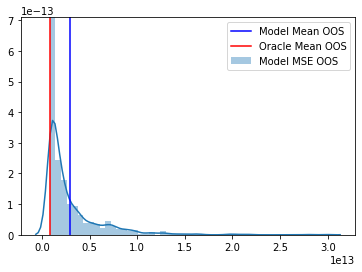

In [519]:
# Check the MSE of the nonrobust model against out-of-sample.
# Check the results of MSE and MAE from the robust regression. Now, the MSE:
# Plotting the results of GEV noise and MAE.
ax = sns.distplot(model_mse_results, label = 'Model MSE OOS')

ax.axvline(np.mean(model_mse_results), color = 'b', label = 'Model Mean OOS')
ax.axvline(oracle_mse_results, color = 'r', label = 'Oracle Mean OOS')

ax.legend()

print('Model Mean: ', np.mean(model_mse_results),
      '. Oracle mean: ', np.mean(oracle_mse_results),
      '. Difference: ', np.mean(model_mse_results) - np.mean(oracle_mse_results),
      '. Difference as % of oracle: ', (np.mean(model_mse_results) - oracle_mse_results) / oracle_mse_results)

Model Mean:  1312150.7025280625 . Oracle mean:  445395.4820212164 . Difference:  866755.2205068461 . Difference as % of oracle:  1.9460350531026676


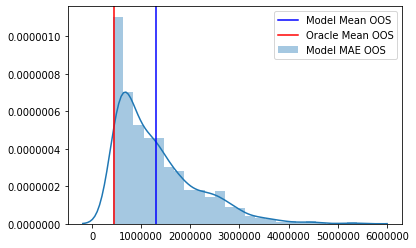

In [520]:
# Check the MSE of the nonrobust model against out-of-sample.
# Check the results of MSE and MAE from the robust regression. Now, the MSE:
# Plotting the results of GEV noise and MAE.
ax = sns.distplot(model_mae_results, label = 'Model MAE OOS')

ax.axvline(np.mean(model_mae_results), color = 'b', label = 'Model Mean OOS')
ax.axvline(oracle_mae_results, color = 'r', label = 'Oracle Mean OOS')

ax.legend()

print('Model Mean: ', np.mean(model_mae_results),
      '. Oracle mean: ', np.mean(oracle_mae_results),
      '. Difference: ', np.mean(model_mae_results) - np.mean(oracle_mae_results),
      '. Difference as % of oracle: ', (np.mean(model_mae_results) - oracle_mae_results) / oracle_mae_results)

Model Mean:  1038925686147.1705 . Oracle mean:  893144204599.7822 . Difference:  145781481547.3883 . Difference as % of oracle:  0.16322278171497845


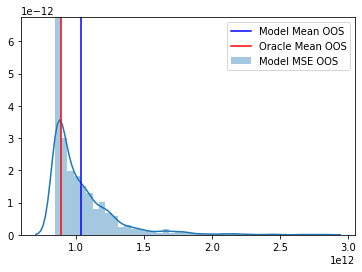

In [521]:
# Check the MSE of the robust model against out-of-sample.
# Check the results of MSE and MAE from the robust regression. Now, the MSE:
# Plotting the results of GEV noise and MAE.
ax = sns.distplot(robust_mse_results, label = 'Robust Model MSE OOS')

ax.axvline(np.mean(robust_mse_results), color = 'b', label = 'Robust Model Mean OOS')
ax.axvline(oracle_mse_results, color = 'r', label = 'Oracle Mean OOS')

ax.legend()

print('Model Mean: ', np.mean(robust_mse_results),
      '. Oracle mean: ', np.mean(oracle_mse_results),
      '. Difference: ', np.mean(robust_mse_results) - np.mean(oracle_mse_results),
      '. Difference as % of oracle: ', (np.mean(robust_mse_results) - oracle_mse_results) / oracle_mse_results)

Model Mean:  540582.2790151819 . Oracle mean:  445395.4820212164 . Difference:  95186.79699396552 . Difference as % of oracle:  0.2137129828125003


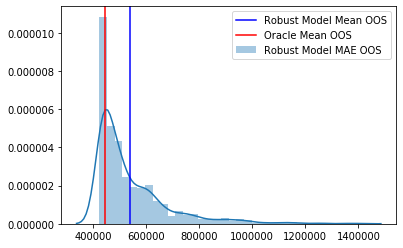

In [522]:
# Check the MAE of the robust model against out-of-sample.
# Check the results of MSE and MAE from the robust regression. Now, the MAE:
# Plotting the results of GEV noise and MAE.
ax = sns.distplot(robust_mae_results, label = 'Robust Model MAE OOS')

ax.axvline(np.mean(robust_mae_results), color = 'b', label = 'Robust Model Mean OOS')
ax.axvline(oracle_mae_results, color = 'r', label = 'Oracle Mean OOS')

ax.legend()

print('Model Mean: ', np.mean(robust_mae_results),
      '. Oracle mean: ', np.mean(oracle_mae_results),
      '. Difference: ', np.mean(robust_mae_results) - np.mean(oracle_mae_results),
      '. Difference as % of oracle: ', (np.mean(robust_mae_results) - oracle_mae_results) / oracle_mae_results)

If I take samples that are out of the original sampling range for my variables, then the performances of the regression are significantly worse
for errors distributed with generalized extreme value distributions. That's somewhat to be expected, since one of the assumptions is that the
data you are trying to predict is drawn from the same distribution as the training data, and by sampling outside of the original range, that
assumption no longer holds. However, it may be worth doing to a less extreme extent (ie., we could sample from alternating blocks for
training and test data within a given range).
